### About the Dataset: UIT-VSMEC
Emotion recognition, a specialized field within sentiment analysis, delves into a nuanced understanding of text sentiments beyond mere positive or negative polarity or numerical ratings. Instead, it discerns emotions such as enjoyment, disgust, sadness, anger, surprise, fear, and others, offering a richer insight into text sentiment. In the pursuit of advancing emotion recognition research in Vietnamese, a low-resource language in Natural Language Processing (NLP), the University of Information Technology (UIT) has developed the Vietnamese Social Media Emotion Corpus (UIT-VSMEC).

UIT-VSMEC comprises approximately 6,927 human-annotated sentences, each labeled with one of six emotion categories. This corpus serves as a standardized benchmark for emotion recognition tasks, facilitating the evaluation and comparison of machine learning and deep neural network models. The development of UIT-VSMEC not only contributes significantly to Vietnamese emotion recognition research but also addresses the scarcity of resources for NLP in Vietnamese. Among the various models assessed on UIT-VSMEC, Convolutional Neural Network (CNN) emerged with the highest performance, achieving a notable F1-score of 57.61%.

Through UIT-VSMEC, researchers and practitioners are equipped with a valuable resource to delve into the intricacies of emotion recognition in Vietnamese text, thereby enhancing the understanding of customer sentiments and augmenting brand value assessment methodologies. This corpus stands as a testament to the continuous efforts in advancing NLP capabilities for languages with limited resources, fostering innovation and progress in the field of emotion recognition.

## Set Up

In this section, starting by installing necessary libraries and packages for project. Installing `openpyxl`, a library for reading Excel files, and then proceed to install other libraries like `pandas`, `seaborn`, `matplotlib`, `gensim`, `scikit-learn`, and `transformers`. These libraries are essential for data manipulation, visualization, machine learning modeling, and BERT-based text processing.

In [1]:
# For read excel format form pandas
!pip install openpyxl

In [2]:
!pip install pandas seaborn matplotlib gensim scikit-learn transformers

In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from torch import nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
#warnings.filterwarnings("ignore")

logging.set_verbosity_error()

D:\anaconda3\envs\env_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check for the availability of CUDA for GPU acceleration, which can significantly speed up model training if available.

In [4]:

# Check if CUDA is available
print(torch.cuda.is_available())

# Get the CUDA device count
print(torch.cuda.device_count())

# Get the CUDA device name
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3060


Initialize hyperparameters for machine.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() is True else 'cpu')
#device = torch.device('cpu')
EPOCHS = 6
N_SPLITS = 5

## Load Data

This section defines functions to load data from Excel files into Pandas DataFrames. I have training, validation, and testing datasets. The training dataset is further split using stratified k-fold cross-validation, a technique to ensure each fold has a proportional representation of different classes.

In [6]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

train_df = get_data('train_nor_811.xlsx')
valid_df = get_data('valid_nor_811.xlsx')
test_df = get_data('test_nor_811.xlsx')

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

In [7]:
train_df.sample(5)

,Emotion,Sentence,kfold
5142,Enjoyment,lời được cánh của sắt tàu hỏa ngon rồi,4.0
5350,Enjoyment,per nói bao nhiêu lần cũng không thấy đủ ... e...,4.0
5461,Fear,t chỉ sợ cảnh đấu kiếm :((,4.0
4198,Disgust,đúng là tuổi tác nó không chứng minh được gì c...,3.0
4855,Other,cô ơi nhiệt tình là tốt nhưng bản thân phải an...,3.0


In [8]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

**=> No Missing Values**

<Axes: xlabel='Emotion', ylabel='count'>

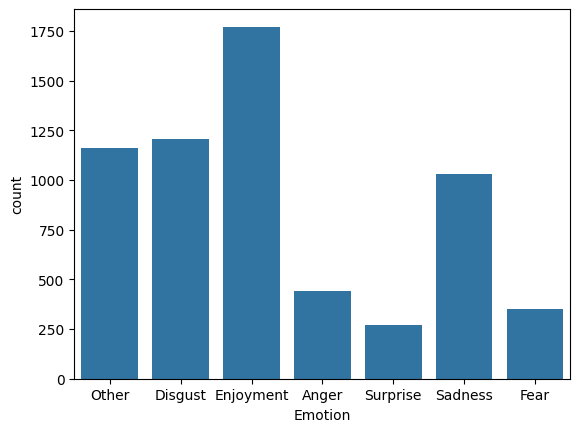

In [9]:
sns.countplot(x='Emotion', data=train_df)

**=> Imbalanced labels! But no class will be drop to fully analysis the sentiment**

## DataLoader

Define a custom PyTorch Dataset class called `SentimentDataset` to prepare data for training. This class tokenizes the text using PhoBERT tokenizer, encodes tokens, and generates attention masks for variable-length sequences. Each sample in the dataset consists of tokenized text, input IDs, attention masks, and target labels.


In [10]:
# Initialize the AutoTokenizer from Hugging Faces
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [11]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])

        return text, label

## BERT works with fixed-length sequences. Use a simple strategy to choose the max length.

This part visualizes the distribution of the length of sentences in our dataset by choosing a maximum length of 50 tokens based on this distribution to ensure BERT can handle the input sequences efficiently. (overchosen will lead to overfitting)

Text(0.5, 9.444444444444438, 'Token Count')

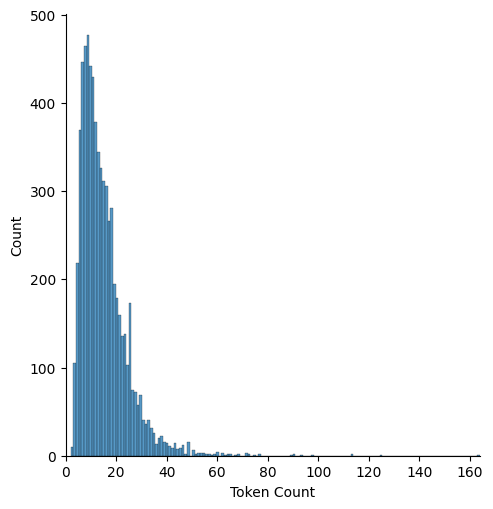

In [12]:
# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**=> Choose a maximum of length of 50 is safe.**

## Model

Define Sentiment Classifier model using PyTorch. The model utilizes PhoBERT as the backbone transformer model, with a dropout layer for regularization and a linear layer for classification. Initialization of weights and biases is performed according to recommended practices.

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        
        # Prevent overfitting with dropout probability=0.3
        self.drop = nn.Dropout(p=0.3)
        
        # Fully connected linear layer that map to n_classes
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

## Train & Eval Function

This section defines functions for training and evaluation of the model. The `train` function trains the model on the training data, while the `eval` function evaluates the model's performance on the validation data. Cross-entropy loss as the optimization criterion is used.


In [14]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


## Training with K-Fold

This part implements training using k-fold cross-validation. For each fold, the dataset is split into training and validation sets, and the model is trained and evaluated. Adam optimizer with a linear learning rate scheduler for optimization is used.


In [15]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
    
    return train_loader, valid_loader

In [16]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    
    
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.38419891718468013 Loss: 1.6519705685667503
Valid Accuracy: 0.5252606255012029 Loss: 1.3389228605307066
Epoch 2/6
------------------------------
Train Accuracy: 0.5570483256466814 Loss: 1.256864852248094
Valid Accuracy: 0.5757818765036087 Loss: 1.1847159090714576
Epoch 3/6
------------------------------
Train Accuracy: 0.652295969520754 Loss: 1.0163829069680128
Valid Accuracy: 0.5894145950280674 Loss: 1.1515581814142375
Epoch 4/6
------------------------------
Train Accuracy: 0.7130539402446361 Loss: 0.8441015903193217
Valid Accuracy: 0.5942261427425822 Loss: 1.2237771722750785
Epoch 5/6
------------------------------
Train Accuracy: 0.7675957489472629 Loss: 0.7049607330789933
Valid Accuracy: 0.6150761828388132 Loss: 1.1808195538245714
Epoch 6/6
------------------------------
Train Accuracy: 0.7998796871866853 Loss: 0.6184582800055162
Valid Accuracy: 0.6190858059342421 Loss: 1.19547501206398

## Test

In this section, define a function to test the trained model on the test dataset. The function loads saved models from each fold, aggregates predictions, and calculates performance metrics such as accuracy and F1-score using classification report and confusion matrix.

In [17]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [18]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       193
           1       0.59      0.59      0.59       132
           2       0.63      0.66      0.64       116
           3       0.43      0.33      0.37        40
           4       0.65      0.41      0.50        37
           5       0.68      0.70      0.69        46
           6       0.52      0.57      0.54       129

    accuracy                           0.61       693
   macro avg       0.60      0.56      0.57       693
weighted avg       0.61      0.61      0.60       693



**=> F1-score reach 61% (acceptable base on dataset best F1-score performance ~57.61%)**

## Heatmap between Predict and Ground Truth

This part visualizes the confusion matrix between predicted and ground truth labels to understand the model's performance 
across different classes.


<Axes: >

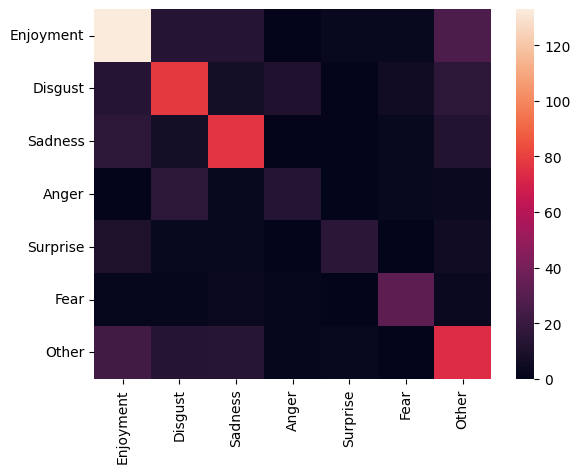

In [19]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

**=> Label Fear is the most unrelated to others -> Distinguished from others -> Highest F1-Score**

## Visualize Wrong Predicted Label

Extract and display some examples where the model's predictions do not match the ground truth labels. This helps in understanding potential areas of improvement for the model.

In [20]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
kinh vãi 😡
Predicted: (Anger) --vs-- Real label: (Fear)
--------------------------------------------------
bắt cóc bỏ đĩa . quanh đi quẩn lại chỉ khổ dân đen thôi !
Predicted: (Disgust) --vs-- Real label: (Enjoyment)
--------------------------------------------------
mấy ai được như vậy ??
Predicted: (Enjoyment) --vs-- Real label: (Disgust)
--------------------------------------------------
ổng quay thiệt mà sao chửi ổng thế . không quay sao máy bạn xem được đó :))
Predicted: (Enjoyment) --vs-- Real label: (Other)
--------------------------------------------------
nghe ngọt thế :((
Predicted: (Enjoyment) --vs-- Real label: (Disgust)
--------------------------------------------------
sao lại cứ phải thế nhỉ
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
hậu duệ mặt trời đấy chứ đùa đâu nhá 😗😗
Predicted: (Enjoyment) --vs-- Real label: (Other)
------------------------------------------

## Inference

Finally, define a function to perform inference on new text inputs using the trained model. The function tokenizes the input text, feeds it to the model, and predicts the sentiment label.


In [21]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [33]:
infer('Khánh đẹp trai quá', tokenizer)

Text: Khánh đẹp trai quá
Sentiment: Enjoyment
